# Import

In [20]:
#%matplotlib notebook
import numpy as np
from scipy.stats import norm
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.pyplot as plt
import statistics
from scipy import signal
from scipy.optimize import curve_fit
import scipy.fftpack

# Reading files

In [21]:
# Rl = 90; N=256
# folder_in = "dt_003_T_25/"
# run_files=[30, 51, 79, 86, 85, 77, 89]

Rl = 60; N=128
folder_in = "big_ts/abs/"
run_files=[999, 999, 746]

common_folder = "/home/gorbunov8a/Documents/MATLAB/data/corr/"
correlation_type = "two_point_corr"
spec_component = "avg"
spec_type = "lin"

nb_of_runs = len(run_files)
for run_index in list(range(nb_of_runs)) :
    folder = common_folder + "rl" + str(Rl) + "_N" + str(N) + "/" + folder_in + "run" + "%01d" % (run_index+1) + "/"
    file = folder + correlation_type + "_" + spec_type + "_C" + spec_component + "_wi=" + "%03d" % run_files[run_index] + ".table"
    file_data = []
    for line in open(file) :
        temp_array_line = []
        if line[0] == '#' :          #skip commented lines
            continue
        else :
            temp_array_line=list(map(float, line.split( )))
            file_data.append(temp_array_line)
    if not('accumulated_data' in dir()) : 
        accumulated_data = file_data.copy()
    else : 
        accumulated_data = list(map(lambda l1, l2: [sum(x) for x in zip(l1, l2)], accumulated_data, file_data))
averaging_coef = 1.0/nb_of_runs
k = np.array(accumulated_data[0])*averaging_coef
nb_of_modes = np.array(accumulated_data[1])*averaging_coef

average_data = np.ndarray(shape=(len(accumulated_data)-2, k.shape[0]+1), dtype=float)
for i in list(range(average_data.shape[0])) : 
    average_data[i, :] = np.array(accumulated_data[i+2])*averaging_coef
t = average_data[:,0]
correlation_mean = np.array(average_data[:,1:])

del average_data, file_data, accumulated_data

# Define parameters

In [22]:
# PARAMETERS
if (Rl == 90) :
    lmbda = 0.268 
    eta = 0.0134  
    L=2.65
    dissipation_rate=0.31e-04
    urms=np.sqrt(3*0.2282712E-02/2)
elif (Rl == 60) :
    lmbda = 0.387 
    eta = 0.025  
    L=2.65 
    dissipation_rate=2.24565e-06
t0=dissipation_rate**(-1/3)*L**(2/3)

normalization_status = True

# Normalization

In [23]:
t_length=t.shape[0]
wavenumbers_length=k.shape[0]
if normalization_status :
    t=t/t0
    k=k*L
    normalization = np.power(correlation_mean[0,:],-1.0)
else : 
    normalization = np.ones(wavenumbers_length)

# Plotting params

In [24]:
kmin = 4
kmax = 12
nb_of_curves = 5
step = round((kmax - kmin)/nb_of_curves)
indices_of_k_to_plot=list(range(kmin,kmax,step))
indices_of_k_to_plot.append(50)
print(indices_of_k_to_plot)

[4, 6, 8, 10, 50]


# Plot spatial spectrum

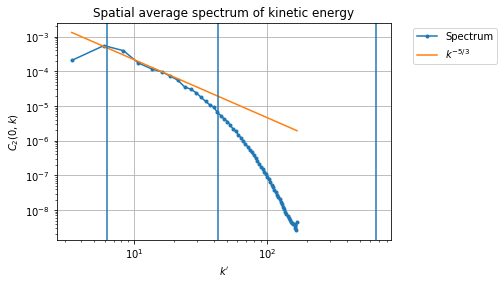

In [25]:
spatial_spectrum = np.zeros(shape=wavenumbers_length, dtype=float)
for ik in list(range(wavenumbers_length)) : 
    spatial_spectrum[ik] = 4*np.pi*correlation_mean[0,ik]*k[ik]*k[ik]/nb_of_modes[ik]
plt.plot(k, spatial_spectrum, '.-', label='Spectrum')
plt.plot(k, 10e-3*k**(-5.0/3.0), label=r'$k^{-5/3}$')
plt.xscale('log'); plt.yscale('log')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel(r'$k^\prime$'); plt.ylabel(r'$C_2(0,k)$')
plt.title('Spatial average spectrum of kinetic energy')
plt.axvline(x=2*np.pi/lmbda*L); plt.axvline(x=2*np.pi/L*L); plt.axvline(x=2*np.pi/eta*L)
plt.grid()
plt.show()

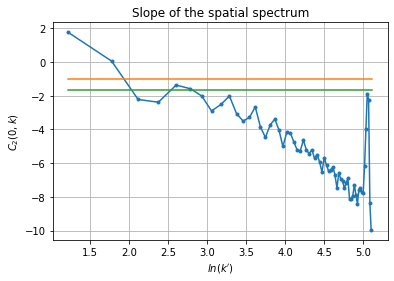

In [26]:
# check the slope of the spectrum
resampling = 1
x = np.log(k[::resampling])
f = np.log(spatial_spectrum[::resampling])
slope = np.gradient(f, x)
plt.plot(x[:-2:], slope[:-2:], '.-')
plt.plot(x[:-1:], -1*np.ones_like(x[:-1:]), '-')
plt.plot(x[:-1:], -5/3*np.ones_like(x[:-1:]), '-')
plt.xlabel(r'$ln(k^\prime)$'); plt.ylabel(r'$C_2(0,k)$')
plt.title('Slope of the spatial spectrum')
plt.grid()
plt.show()

# Plot correlation

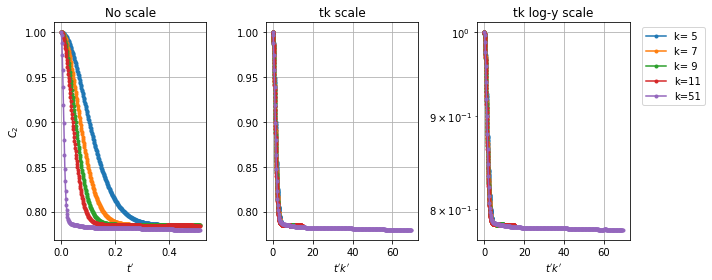

In [27]:
tk1 = 0.0
tk2 = 100.0

fig, (norm_scale, tk_scale, log_scale) = plt.subplots(nrows=1, ncols=3,figsize=(10,4))
for ik in indices_of_k_to_plot :
    a = np.searchsorted(t*k[ik], tk1)
    b = np.searchsorted(t*k[ik], tk2)
    norm_scale.plot(t, correlation_mean[:,ik]*normalization[ik], '.-')
    tk_scale.plot(t[a:b]*k[ik], correlation_mean[a:b,ik]*normalization[ik], '.-')
    log_scale.semilogy(t[a:b]*k[ik], correlation_mean[a:b,ik]*normalization[ik], '.-', label='k=%2.f' % (k[ik]/L))
norm_scale.set(title='No scale', ylabel=r'$C_2$', xlabel=r'$t^\prime$'); norm_scale.grid()
tk_scale.set(title='tk scale', xlabel=r'$t^\prime k^\prime$'); tk_scale.grid()
log_scale.set(title='tk log-y scale', xlabel=r'$t^\prime k^\prime$'); log_scale.grid()
log_scale.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
fig.tight_layout()
plt.show()

# FFT of correlation

In [28]:
N = t_length
delta = t[1]-t[0]
nu = np.fft.fftfreq(N, delta)
yplot = np.ndarray(shape=(N, wavenumbers_length), dtype=complex)
for ik in list(range(wavenumbers_length)) :
    yf = np.fft.fft(correlation_mean[:,ik])
    yplot[:, ik] = yf

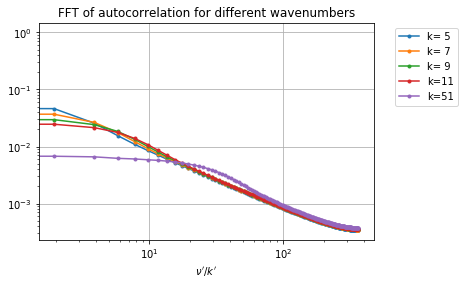

In [29]:
for ik in indices_of_k_to_plot :
    spectrum = 1.0/N * np.absolute(yplot[:, ik])
    norm_coef = spectrum[0]
    #horizontal_scale = 1.0/k[ik]
    horizontal_scale = 1.0
    plt.plot(nu[0:N//2]*horizontal_scale, spectrum[0:N//2]/norm_coef, '.-', label='k=%2.f' % (k[ik]/L))
    #plt.plot(nu, 1.0/N * np.imag(yplot[:, ik]), label='k=%2.f' % k[ik])
#plt.xlim(-15, 15) 
#plt.plot(nu[1:N//2]*horizontal_scale, 10e-2*nu[1:N//2]**(-1), 'k-', label=r'$\nu^{-1}$')
plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'$\nu^\prime / k^\prime$')
plt.title('FFT of autocorrelation for different wavenumbers')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

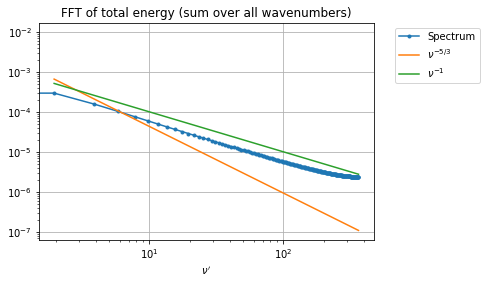

In [30]:
total_energy_spectrum = np.zeros(shape=yplot.shape[0], dtype=float)
range_of_k = list(range(wavenumbers_length))
for ik in range_of_k : 
    spectrum = np.absolute(yplot[:, ik])
    total_energy_spectrum = total_energy_spectrum + 4.0*np.pi*spectrum*k[ik]*k[ik]/nb_of_modes[ik]
    #total_energy_spectrum = total_energy_spectrum + spectrum
total_energy_spectrum = total_energy_spectrum/len(range_of_k)
total_energy_spectrum = total_energy_spectrum*10.0e-1
plt.plot(nu[0:N//2], total_energy_spectrum[0:N//2], '.-', label='Spectrum')
plt.plot(nu[1:N//2], 2.0e-3*nu[1:N//2]**(-5.0/3.0), label=r'$\nu^{-5/3}$')
plt.plot(nu[1:N//2], 10e-4*nu[1:N//2]**(-1.0), label=r'$\nu^{-1}$')
#plt.plot(nu[1:N//2], 10e-4*nu[1:N//2]**(-2.0), label=r'$\nu^{-2}$')
plt.xscale('log'); plt.yscale('log')
plt.xlabel(r'$\nu^\prime$')
plt.title('FFT of total energy (sum over all wavenumbers)')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

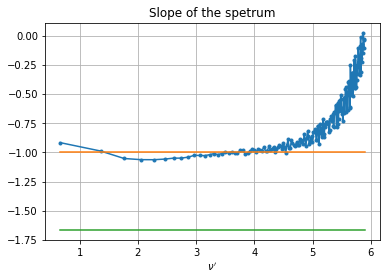

In [31]:
# check the slope of the spectrum
resampling = 1
x = np.log(nu[1:N//2:resampling])
f = np.log(total_energy_spectrum[1:N//2:resampling])
slope = np.gradient(f, x)
plt.plot(x[:-2:], slope[:-2:], '.-')
plt.plot(x[:-1:], -1*np.ones_like(x[:-1:]), '-')
plt.plot(x[:-1:], -5/3*np.ones_like(x[:-1:]), '-')
plt.xlabel(r'$\nu^\prime$')
plt.title('Slope of the spetrum')
plt.grid()
plt.show()

# Correlation fit

In [32]:
# Define the functions to fit

def gaussian(x, a, b, c):   
    return a * np.exp(-b * x**2) + c
gaussian_nb_of_params = 3 

# exponential
def exponent_function(x, a, b, c):   
    return a * np.exp(-b * x) + c
exponent_nb_of_params = 3

## Short time - Gaussian

In [33]:
#define the range of tk for fitting
tk1_gauss = 0.0
tk2_gauss = 8.0

#allocate the vector of fiiting resulting parameters
optim_coef1 = np.ndarray(shape=(wavenumbers_length, gaussian_nb_of_params), dtype=float)
#allocate matrix of fitting error
cov_matrix1 = np.ndarray(shape=(wavenumbers_length, gaussian_nb_of_params, gaussian_nb_of_params), dtype=float)
for ik in range(wavenumbers_length) :
    a = np.searchsorted(t*k[ik], tk1_gauss)
    b = np.searchsorted(t*k[ik], tk2_gauss)
    xdata = t[a:b]*k[ik]   # t'k' variable
    #print('[debug] Fitting using', np.count_nonzero(xdata), 'points')
    ydata = correlation_mean[a:b, ik]*normalization[ik]
    try :
        optim_coef1[ik, :], cov_matrix1[ik, :, :] = curve_fit(gaussian, xdata, ydata)
    except :
        print('Failed optimization for ik = ', ik)
        optim_coef1[ik,:].fill(np.nan)
        continue

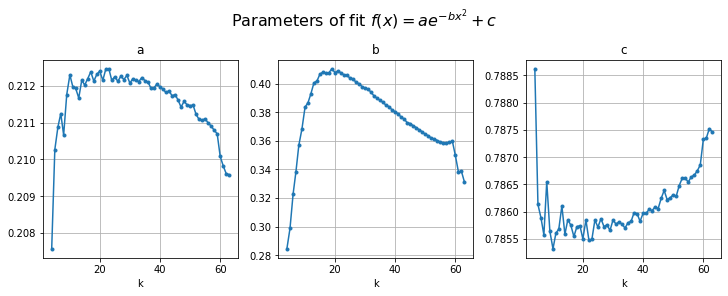

In [34]:
# plot fitting coeffiecients
ik1 = 3; ik2 = wavenumbers_length-1

fig, (ax_a, ax_b, ax_c) = plt.subplots(nrows=1, ncols=3,figsize=(10,4), constrained_layout=True)
ax_a.plot(k[ik1:ik2]/L, optim_coef1[ik1:ik2, 0], '.-')
ax_b.plot(k[ik1:ik2]/L, optim_coef1[ik1:ik2, 1], '.-')
ax_c.plot(k[ik1:ik2]/L, optim_coef1[ik1:ik2, 2], '.-')
ax_a.set(title='a', xlabel='k'); ax_a.grid()
ax_b.set(title='b', xlabel='k'); ax_b.grid()
ax_c.set(title='c', xlabel='k'); ax_c.grid()
fig.suptitle(r'Parameters of fit $f(x) = a e^{-b x^2} + c$', fontsize=16)
plt.show()

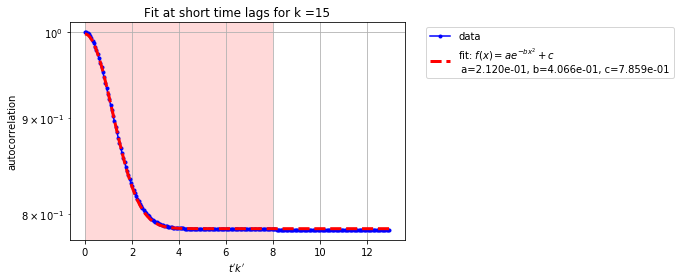

In [35]:
# Example of the gaussian fit for one wavenumber
ik = 14
a = np.searchsorted(t*k[ik], tk1_gauss)
b = np.searchsorted(t*k[ik], tk2_gauss+5)
coef_vector = optim_coef1[ik,:]
plt.plot(t[a:b]*k[ik], correlation_mean[a:b, ik]*normalization[ik], 'b.-', label='data')
plt.plot(t[a:b]*k[ik], gaussian(t[a:b]*k[ik], *coef_vector), 'r--', linewidth=3, label=r'fit: $f(x) = a e^{-b x^2} + c$' + "\n" + ' a=%5.3e, b=%5.3e, c=%5.3e' % tuple(coef_vector))
plt.xlabel(r'$t^\prime k^\prime$'); plt.ylabel('autocorrelation'); plt.grid()
plt.axvspan(tk1_gauss, tk2_gauss, facecolor='red', alpha=0.15)
plt.title('Fit at short time lags for k =%2.f' % (k[ik]/L))
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.yscale("log")
plt.show()

## Long time lags

In [36]:
# fitting range : 
tk1_long = 4.0
tk2_long = 6.0

optim_coef2 = np.ndarray(shape=(wavenumbers_length, 3), dtype=float)
cov_matrix2 = np.ndarray(shape=(wavenumbers_length, 3, 3), dtype=float)
for ik in range(wavenumbers_length) :
    a = np.searchsorted(t*k[ik], tk1_long)
    b = np.searchsorted(t*k[ik], tk2_long)
    xdata = t[a:b]*k[ik]
    #print('[debug] Fitting using', np.count_nonzero(xdata), 'points')
    ydata = correlation_mean[a:b, ik]*normalization[ik]
    try :
        optim_coef2[ik, :], cov_matrix2[ik,:,:] = curve_fit(exponent_function, xdata, ydata)
    except :
        print('Failed optimization for ik = ', ik)
        optim_coef2[ik,:].fill(np.nan)
        continue
    max_param_std = 100
    if (np.count_nonzero(np.sqrt(np.diag(cov_matrix2[ik,:,:])>max_param_std)) > 0) :
        print('point out ik = ', ik)
        cov_matrix2[ik,:,:].fill(np.nan)
        optim_coef2[ik,:].fill(np.nan)

Failed optimization for ik =  0
Failed optimization for ik =  1
point out ik =  49
point out ik =  54


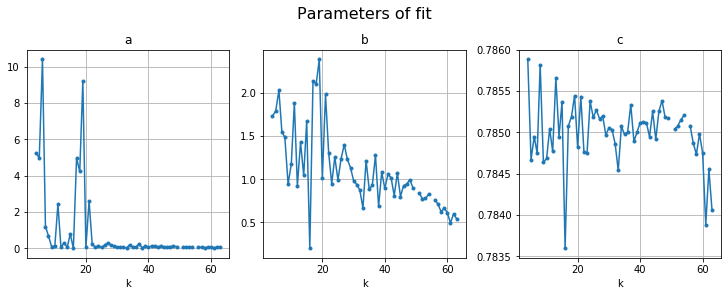

In [37]:
# plot fitting coeffiecients
fig, (ax_a, ax_b, ax_c) = plt.subplots(nrows=1, ncols=3,figsize=(10,4), constrained_layout=True)
ik1 = 3; ik2 = wavenumbers_length-1
ax_a.plot(k[ik1:ik2]/L, optim_coef2[ik1:ik2, 0],'.-')
ax_b.plot(k[ik1:ik2]/L, optim_coef2[ik1:ik2, 1],'.-')
ax_c.plot(k[ik1:ik2]/L, optim_coef2[ik1:ik2, 2],'.-')
ax_a.set(title='a', xlabel='k'); ax_a.grid()
ax_b.set(title='b', xlabel='k'); ax_b.grid()
ax_c.set(title='c', xlabel='k'); ax_c.grid()
fig.suptitle('Parameters of fit', fontsize=16)
plt.show()

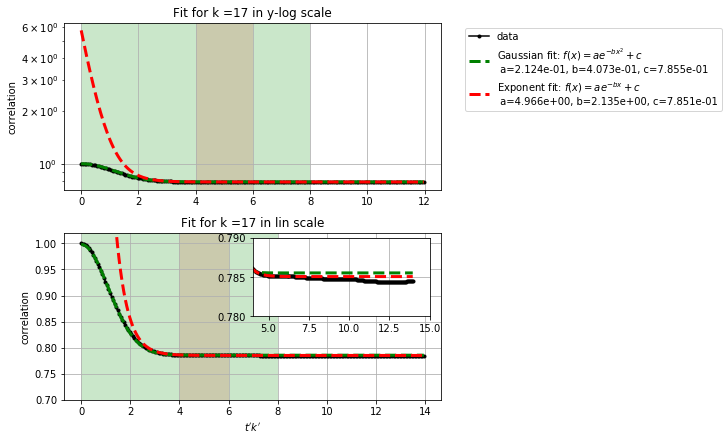

In [38]:
# Example of the exponential fit for one wavenumber
ik = 16
a = np.searchsorted(t*k[ik], 0)
b = np.searchsorted(t*k[ik], tk1_long+8)
coef_vector = optim_coef2[ik,:]

fig, (ax_log, ax_lin) = plt.subplots(nrows=2, ncols=1, figsize=(10,6), constrained_layout=True)
ax_log.plot(t[a:b]*k[ik], correlation_mean[a:b, ik]*normalization[ik], 'k.-', label='data')
ax_log.plot(t[a:b]*k[ik], gaussian(t[a:b]*k[ik], *optim_coef1[ik,:]), 'g--', linewidth=3, label=r'Gaussian fit: $f(x) = a e^{-b x^2} + c$' + "\n" + ' a=%5.3e, b=%5.3e, c=%5.3e' % tuple(optim_coef1[ik,:]))
ax_log.plot(t[a:b]*k[ik], exponent_function(t[a:b]*k[ik], *optim_coef2[ik,:]), 'r--', linewidth=3, label=r'Exponent fit: $f(x) = a e^{-b x} + c$' + "\n" + ' a=%5.3e, b=%5.3e, c=%5.3e' % tuple(optim_coef2[ik,:]))
ax_log.axvspan(tk1_long, tk2_long, facecolor='red', alpha=0.15)
ax_log.axvspan(tk1_gauss, tk2_gauss, facecolor='#2ca02c', alpha=0.25)
ax_log.set(yscale="log", ylabel='correlation', title='Fit for k =%2.f' % (k[ik]/L) +' in y-log scale'); ax_log.grid()
ax_log.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

a = np.searchsorted(t*k[ik], 0)
b = np.searchsorted(t*k[ik], tk1_long+10)
ax_lin.plot(t[a:b]*k[ik], correlation_mean[a:b, ik]*normalization[ik], 'k.-', label='data')
ax_lin.plot(t[a:b]*k[ik], gaussian(t[a:b]*k[ik], *optim_coef1[ik,:]), 'g--', linewidth=3, label=r'Gaussian fit: $f(x) = a e^{-b x^2} + c$' + "\n" + ' a=%5.3e, b=%5.3e, c=%5.3e' % tuple(optim_coef1[ik,:]))
ax_lin.plot(t[a:b]*k[ik], exponent_function(t[a:b]*k[ik], *optim_coef2[ik,:]), 'r--', linewidth=3, label=r'Exponent fit: $f(x) = a e^{-b x} + c$' + "\n" + ' a=%5.3e, b=%5.3e, c=%5.3e' % tuple(optim_coef2[ik,:]))
ax_lin.axvspan(tk1_long, tk2_long, facecolor='red', alpha=0.15)
ax_lin.axvspan(tk1_gauss, tk2_gauss, facecolor='#2ca02c', alpha=0.25)
ax_lin.set(ylim=(0.7,1.02), xlabel=r'$t^\prime k^\prime$', ylabel='correlation',title='Fit for k =%2.f' % (k[ik]/L) +' in lin scale'); ax_lin.grid()

zoom = ax_lin.inset_axes([0.5, 0.5, 0.47, 0.47])
zoom.plot(t[a:b]*k[ik], correlation_mean[a:b, ik]*normalization[ik], 'k.-', label='data')
zoom.plot(t[a:b]*k[ik], gaussian(t[a:b]*k[ik], *optim_coef1[ik,:]), 'g--', linewidth=3, label=r'Gaussian fit: $f(x) = a e^{-b x^2} + c$' + "\n" + ' a=%5.3e, b=%5.3e, c=%5.3e' % tuple(optim_coef1[ik,:]))
zoom.plot(t[a:b]*k[ik], exponent_function(t[a:b]*k[ik], *optim_coef2[ik,:]), 'r--', linewidth=3, label=r'Exponent fit: $f(x) = a e^{-b x} + c$' + "\n" + ' a=%5.3e, b=%5.3e, c=%5.3e' % tuple(optim_coef2[ik,:]))
#zoom.axvspan(tk1_long, tk2_long, facecolor='red', alpha=0.15)
#zoom.axvspan(tk1_gauss, tk2_gauss, facecolor='#2ca02c', alpha=0.25)
zoom.set(ylim=(0.78,0.79), xlim=(4,15), yscale="linear"); zoom.grid()
plt.show()